# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

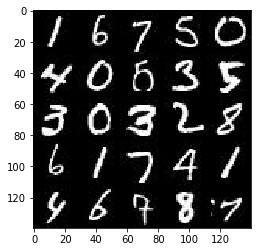

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

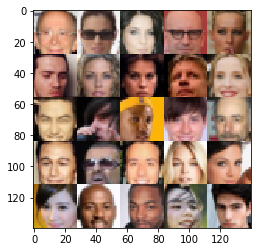

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), 
                                 name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_real, inputs_z, learn_rate




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    d_depths = [64, 128, 256]
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        # conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #leaky ReLu
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x32
        
        # conv 2
        # 7x7x128
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # conv 3
        # 4x4x256 
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        

        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        # Logit
        logits = tf.layers.dense(flat, 1)
        #discriminator output sigmoid(probility output)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    g_depths= [ 512, 256, 128]
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected layer
        fc = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        fc = tf.reshape(fc, (-1, 2, 2, 512))
        fc = tf.maximum(alpha * fc, fc)
        # 4x4x512 now
        
        deconv2 = tf.layers.conv2d_transpose(fc, 256, 5, strides=2, padding='valid')
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_train)
        deconv2 = tf.maximum(alpha * deconv2, deconv2)
        # 16x16x256 now
        
        deconv3 = tf.layers.conv2d_transpose(deconv2, 128, 5, strides=2, padding='same')
        deconv3 = tf.layers.batch_normalization(deconv3, training=is_train)
        deconv3 = tf.maximum(alpha * deconv3, deconv3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(deconv3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        #output Tanh
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function  
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))#*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 2.3991... Generator Loss: 0.1029
Epoch 0/2... Discriminator Loss: 0.0523... Generator Loss: 7.7149
Epoch 0/2... Discriminator Loss: 2.0293... Generator Loss: 0.1602
Epoch 0/2... Discriminator Loss: 0.1984... Generator Loss: 7.7966
Epoch 0/2... Discriminator Loss: 0.3481... Generator Loss: 9.9057
Epoch 0/2... Discriminator Loss: 0.0691... Generator Loss: 9.6494
Epoch 0/2... Discriminator Loss: 0.5347... Generator Loss: 1.7702
Epoch 0/2... Discriminator Loss: 0.2642... Generator Loss: 2.0909
Epoch 0/2... Discriminator Loss: 0.4997... Generator Loss: 1.6725


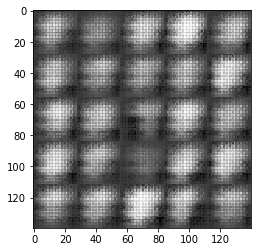

Epoch 0/2... Discriminator Loss: 0.1450... Generator Loss: 2.6591
Epoch 0/2... Discriminator Loss: 0.2578... Generator Loss: 6.1723
Epoch 0/2... Discriminator Loss: 0.4299... Generator Loss: 2.1676
Epoch 0/2... Discriminator Loss: 0.2405... Generator Loss: 2.3472
Epoch 0/2... Discriminator Loss: 0.1898... Generator Loss: 5.2816
Epoch 0/2... Discriminator Loss: 0.1622... Generator Loss: 5.2636
Epoch 0/2... Discriminator Loss: 0.2616... Generator Loss: 7.4163
Epoch 0/2... Discriminator Loss: 0.7524... Generator Loss: 1.1167
Epoch 0/2... Discriminator Loss: 0.3580... Generator Loss: 2.2302
Epoch 0/2... Discriminator Loss: 0.3095... Generator Loss: 2.0001


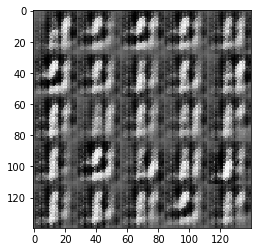

Epoch 0/2... Discriminator Loss: 0.1107... Generator Loss: 3.8355
Epoch 0/2... Discriminator Loss: 2.4819... Generator Loss: 15.1973
Epoch 0/2... Discriminator Loss: 0.2819... Generator Loss: 3.4418
Epoch 0/2... Discriminator Loss: 0.2243... Generator Loss: 3.2836
Epoch 0/2... Discriminator Loss: 0.2682... Generator Loss: 2.2310
Epoch 0/2... Discriminator Loss: 0.1040... Generator Loss: 3.4635
Epoch 0/2... Discriminator Loss: 0.3853... Generator Loss: 2.9665
Epoch 0/2... Discriminator Loss: 0.9344... Generator Loss: 1.8970
Epoch 0/2... Discriminator Loss: 0.2602... Generator Loss: 2.2623
Epoch 0/2... Discriminator Loss: 0.3275... Generator Loss: 1.5973


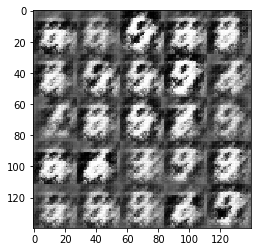

Epoch 0/2... Discriminator Loss: 0.2406... Generator Loss: 2.8042
Epoch 0/2... Discriminator Loss: 0.1275... Generator Loss: 3.0172
Epoch 0/2... Discriminator Loss: 0.1602... Generator Loss: 2.6807
Epoch 0/2... Discriminator Loss: 0.7645... Generator Loss: 6.5819
Epoch 0/2... Discriminator Loss: 0.4456... Generator Loss: 1.6284
Epoch 0/2... Discriminator Loss: 1.3196... Generator Loss: 0.6473
Epoch 0/2... Discriminator Loss: 0.2343... Generator Loss: 2.4554
Epoch 0/2... Discriminator Loss: 0.3130... Generator Loss: 2.0043
Epoch 0/2... Discriminator Loss: 0.1397... Generator Loss: 4.2768
Epoch 0/2... Discriminator Loss: 0.2932... Generator Loss: 2.5081


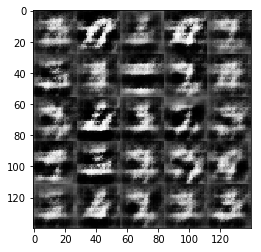

Epoch 0/2... Discriminator Loss: 0.3463... Generator Loss: 2.4391
Epoch 0/2... Discriminator Loss: 0.5132... Generator Loss: 3.5718
Epoch 0/2... Discriminator Loss: 0.3545... Generator Loss: 2.4806
Epoch 0/2... Discriminator Loss: 0.3781... Generator Loss: 2.0685
Epoch 0/2... Discriminator Loss: 0.3355... Generator Loss: 2.3806
Epoch 0/2... Discriminator Loss: 0.3586... Generator Loss: 3.2553
Epoch 0/2... Discriminator Loss: 0.3516... Generator Loss: 2.5924
Epoch 0/2... Discriminator Loss: 1.1568... Generator Loss: 0.9958
Epoch 0/2... Discriminator Loss: 0.5445... Generator Loss: 1.8135
Epoch 0/2... Discriminator Loss: 0.8274... Generator Loss: 3.7256


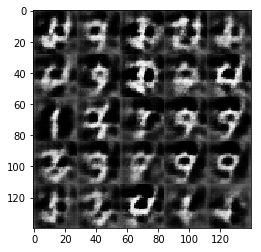

Epoch 0/2... Discriminator Loss: 0.2562... Generator Loss: 2.6079
Epoch 0/2... Discriminator Loss: 0.5213... Generator Loss: 1.5992
Epoch 0/2... Discriminator Loss: 0.2147... Generator Loss: 2.3669
Epoch 0/2... Discriminator Loss: 0.4900... Generator Loss: 2.6634
Epoch 0/2... Discriminator Loss: 0.6281... Generator Loss: 3.3804
Epoch 0/2... Discriminator Loss: 1.3471... Generator Loss: 4.9897
Epoch 0/2... Discriminator Loss: 0.4595... Generator Loss: 2.0351
Epoch 0/2... Discriminator Loss: 1.1839... Generator Loss: 3.7370
Epoch 0/2... Discriminator Loss: 1.0277... Generator Loss: 0.8769
Epoch 0/2... Discriminator Loss: 0.5973... Generator Loss: 1.7112


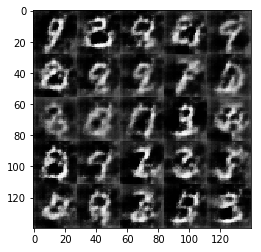

Epoch 0/2... Discriminator Loss: 0.5619... Generator Loss: 1.3550
Epoch 0/2... Discriminator Loss: 0.5391... Generator Loss: 2.2341
Epoch 0/2... Discriminator Loss: 0.6386... Generator Loss: 1.7977
Epoch 0/2... Discriminator Loss: 1.2858... Generator Loss: 4.6586
Epoch 0/2... Discriminator Loss: 1.2839... Generator Loss: 0.5687
Epoch 0/2... Discriminator Loss: 0.6710... Generator Loss: 1.5021
Epoch 0/2... Discriminator Loss: 1.1898... Generator Loss: 3.6087
Epoch 0/2... Discriminator Loss: 1.0049... Generator Loss: 0.7538
Epoch 0/2... Discriminator Loss: 0.4600... Generator Loss: 1.9364
Epoch 0/2... Discriminator Loss: 0.6380... Generator Loss: 1.2551


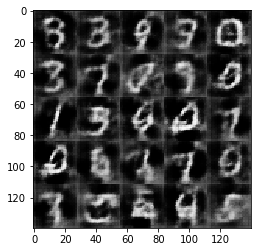

Epoch 0/2... Discriminator Loss: 1.1751... Generator Loss: 3.3243
Epoch 0/2... Discriminator Loss: 0.7606... Generator Loss: 1.8492
Epoch 0/2... Discriminator Loss: 1.1099... Generator Loss: 0.6257
Epoch 0/2... Discriminator Loss: 0.6509... Generator Loss: 1.4999
Epoch 0/2... Discriminator Loss: 1.0717... Generator Loss: 0.7664
Epoch 0/2... Discriminator Loss: 0.8914... Generator Loss: 0.8725
Epoch 0/2... Discriminator Loss: 0.6430... Generator Loss: 1.2235
Epoch 0/2... Discriminator Loss: 0.6423... Generator Loss: 1.4203
Epoch 0/2... Discriminator Loss: 0.6052... Generator Loss: 1.2226
Epoch 0/2... Discriminator Loss: 0.8373... Generator Loss: 2.0149


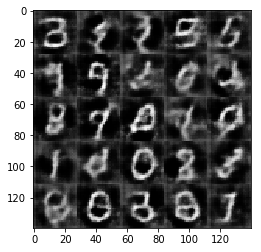

Epoch 0/2... Discriminator Loss: 0.6324... Generator Loss: 1.4413
Epoch 0/2... Discriminator Loss: 0.7474... Generator Loss: 1.1826
Epoch 0/2... Discriminator Loss: 0.8396... Generator Loss: 0.8426
Epoch 0/2... Discriminator Loss: 0.6310... Generator Loss: 1.3756
Epoch 0/2... Discriminator Loss: 0.8872... Generator Loss: 0.8365
Epoch 0/2... Discriminator Loss: 1.2897... Generator Loss: 3.1757
Epoch 0/2... Discriminator Loss: 0.6260... Generator Loss: 1.4091
Epoch 0/2... Discriminator Loss: 1.2897... Generator Loss: 0.4623
Epoch 0/2... Discriminator Loss: 0.7957... Generator Loss: 1.4328
Epoch 0/2... Discriminator Loss: 0.6253... Generator Loss: 2.2863


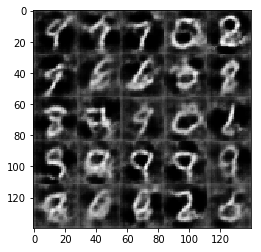

Epoch 0/2... Discriminator Loss: 0.8706... Generator Loss: 2.3528
Epoch 0/2... Discriminator Loss: 0.8682... Generator Loss: 0.8621
Epoch 0/2... Discriminator Loss: 0.7737... Generator Loss: 0.9809
Epoch 0/2... Discriminator Loss: 0.5775... Generator Loss: 1.5241
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 3.9498
Epoch 1/2... Discriminator Loss: 0.7578... Generator Loss: 1.5273
Epoch 1/2... Discriminator Loss: 0.5961... Generator Loss: 1.5274
Epoch 1/2... Discriminator Loss: 0.7535... Generator Loss: 1.7679
Epoch 1/2... Discriminator Loss: 0.6878... Generator Loss: 2.2168
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 1.8208


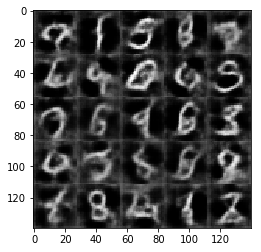

Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.2744
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 0.8560
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 1.5929
Epoch 1/2... Discriminator Loss: 0.5966... Generator Loss: 2.2458
Epoch 1/2... Discriminator Loss: 0.7925... Generator Loss: 1.7958
Epoch 1/2... Discriminator Loss: 0.7522... Generator Loss: 1.4840
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 1.3261
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.2665


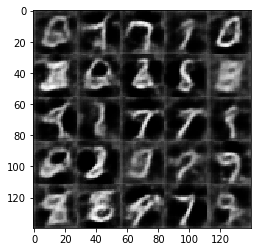

Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 0.6295... Generator Loss: 1.2019
Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 1.3083
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.2586
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 2.0823
Epoch 1/2... Discriminator Loss: 0.7652... Generator Loss: 1.7909
Epoch 1/2... Discriminator Loss: 0.6379... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 0.6725... Generator Loss: 1.2439
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 1.5366
Epoch 1/2... Discriminator Loss: 2.4743... Generator Loss: 0.1370


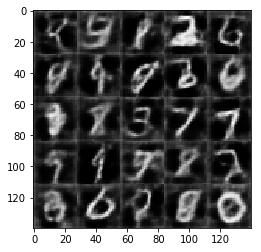

Epoch 1/2... Discriminator Loss: 0.8920... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 0.5898... Generator Loss: 1.5746
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.7450
Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 1.9627
Epoch 1/2... Discriminator Loss: 0.8438... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 0.7552... Generator Loss: 1.0303
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 2.3807
Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 1.4821
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.2625
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 0.7857


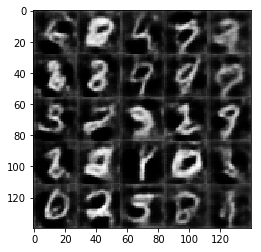

Epoch 1/2... Discriminator Loss: 0.6272... Generator Loss: 1.2579
Epoch 1/2... Discriminator Loss: 0.7063... Generator Loss: 1.2879
Epoch 1/2... Discriminator Loss: 0.9251... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 0.9086... Generator Loss: 1.3883
Epoch 1/2... Discriminator Loss: 0.7126... Generator Loss: 1.4227
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 0.6988... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 0.9427
Epoch 1/2... Discriminator Loss: 0.7291... Generator Loss: 1.8980


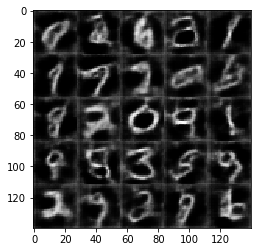

Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.7093
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 1.9088
Epoch 1/2... Discriminator Loss: 0.7663... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 1.2774
Epoch 1/2... Discriminator Loss: 0.8735... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 0.6685... Generator Loss: 1.1469
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 0.7147... Generator Loss: 1.6083


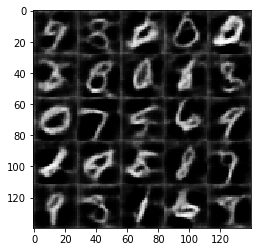

Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 2.6556
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.5161
Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 0.7541
Epoch 1/2... Discriminator Loss: 0.6963... Generator Loss: 1.7833
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 0.5982
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.2094
Epoch 1/2... Discriminator Loss: 0.8472... Generator Loss: 1.5570
Epoch 1/2... Discriminator Loss: 0.6736... Generator Loss: 1.9897
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.5053


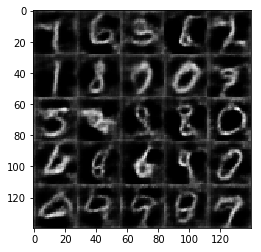

Epoch 1/2... Discriminator Loss: 0.7847... Generator Loss: 1.4729
Epoch 1/2... Discriminator Loss: 0.5025... Generator Loss: 1.6882
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.3261
Epoch 1/2... Discriminator Loss: 0.5691... Generator Loss: 1.7927
Epoch 1/2... Discriminator Loss: 0.9044... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.4385
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 0.6659... Generator Loss: 1.3615
Epoch 1/2... Discriminator Loss: 1.6940... Generator Loss: 0.2706


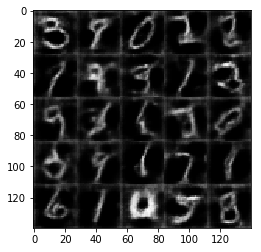

Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 0.6685
Epoch 1/2... Discriminator Loss: 1.5263... Generator Loss: 0.3684
Epoch 1/2... Discriminator Loss: 0.6094... Generator Loss: 1.5961
Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 1.8483... Generator Loss: 0.3270
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 0.6875... Generator Loss: 1.4456
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.5212


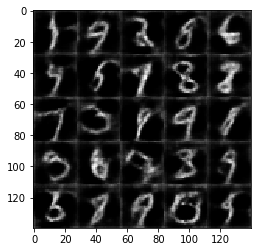

Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 1.4132
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.5013... Generator Loss: 0.3655
Epoch 1/2... Discriminator Loss: 0.6593... Generator Loss: 1.2813
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 1.3055
Epoch 1/2... Discriminator Loss: 0.6475... Generator Loss: 1.2615
Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 1.4027
Epoch 1/2... Discriminator Loss: 0.7886... Generator Loss: 0.9260


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.3410... Generator Loss: 3.8298
Epoch 0/1... Discriminator Loss: 0.1166... Generator Loss: 9.4742
Epoch 0/1... Discriminator Loss: 0.0993... Generator Loss: 6.5632
Epoch 0/1... Discriminator Loss: 0.0295... Generator Loss: 10.0513
Epoch 0/1... Discriminator Loss: 0.1850... Generator Loss: 2.0132
Epoch 0/1... Discriminator Loss: 0.6274... Generator Loss: 13.9321
Epoch 0/1... Discriminator Loss: 0.8532... Generator Loss: 13.5689
Epoch 0/1... Discriminator Loss: 0.3440... Generator Loss: 2.6627
Epoch 0/1... Discriminator Loss: 0.5708... Generator Loss: 8.2074


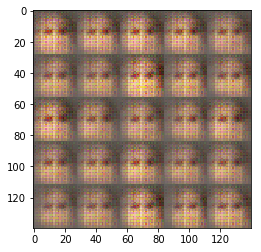

Epoch 0/1... Discriminator Loss: 2.1898... Generator Loss: 0.2735
Epoch 0/1... Discriminator Loss: 0.3463... Generator Loss: 5.0282
Epoch 0/1... Discriminator Loss: 0.8985... Generator Loss: 0.7572
Epoch 0/1... Discriminator Loss: 0.4062... Generator Loss: 3.9356
Epoch 0/1... Discriminator Loss: 0.0779... Generator Loss: 5.7035
Epoch 0/1... Discriminator Loss: 0.5634... Generator Loss: 1.1640
Epoch 0/1... Discriminator Loss: 0.3388... Generator Loss: 5.7650
Epoch 0/1... Discriminator Loss: 1.3386... Generator Loss: 5.0226
Epoch 0/1... Discriminator Loss: 0.4409... Generator Loss: 1.8179
Epoch 0/1... Discriminator Loss: 1.0192... Generator Loss: 0.9165


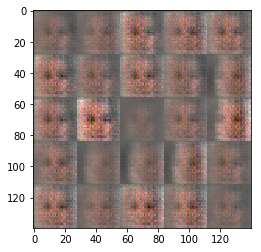

Epoch 0/1... Discriminator Loss: 1.0170... Generator Loss: 0.8889
Epoch 0/1... Discriminator Loss: 1.1466... Generator Loss: 0.8804
Epoch 0/1... Discriminator Loss: 1.0986... Generator Loss: 1.2758
Epoch 0/1... Discriminator Loss: 1.1139... Generator Loss: 2.2804
Epoch 0/1... Discriminator Loss: 1.0180... Generator Loss: 0.9485
Epoch 0/1... Discriminator Loss: 1.1934... Generator Loss: 1.4911
Epoch 0/1... Discriminator Loss: 1.1611... Generator Loss: 0.7062
Epoch 0/1... Discriminator Loss: 0.9288... Generator Loss: 0.9549
Epoch 0/1... Discriminator Loss: 1.2505... Generator Loss: 0.5961
Epoch 0/1... Discriminator Loss: 0.9666... Generator Loss: 0.9897


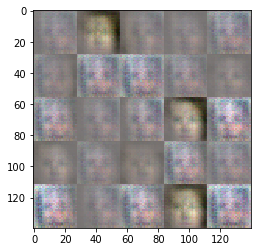

Epoch 0/1... Discriminator Loss: 0.9744... Generator Loss: 1.0461
Epoch 0/1... Discriminator Loss: 1.1738... Generator Loss: 0.8600
Epoch 0/1... Discriminator Loss: 0.7659... Generator Loss: 1.4509
Epoch 0/1... Discriminator Loss: 1.4839... Generator Loss: 0.6282
Epoch 0/1... Discriminator Loss: 1.3465... Generator Loss: 1.4097
Epoch 0/1... Discriminator Loss: 1.1251... Generator Loss: 0.8789
Epoch 0/1... Discriminator Loss: 0.4537... Generator Loss: 1.5563
Epoch 0/1... Discriminator Loss: 0.4989... Generator Loss: 1.8919
Epoch 0/1... Discriminator Loss: 0.8446... Generator Loss: 0.9996
Epoch 0/1... Discriminator Loss: 0.6880... Generator Loss: 1.4667


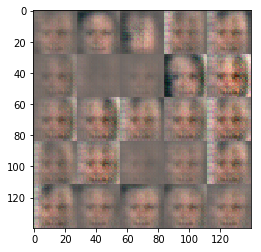

Epoch 0/1... Discriminator Loss: 0.6657... Generator Loss: 1.6966
Epoch 0/1... Discriminator Loss: 0.7719... Generator Loss: 1.5699
Epoch 0/1... Discriminator Loss: 0.8598... Generator Loss: 1.7009
Epoch 0/1... Discriminator Loss: 0.7026... Generator Loss: 3.4757
Epoch 0/1... Discriminator Loss: 0.5221... Generator Loss: 1.3678
Epoch 0/1... Discriminator Loss: 0.6717... Generator Loss: 1.4873
Epoch 0/1... Discriminator Loss: 1.4425... Generator Loss: 5.0179
Epoch 0/1... Discriminator Loss: 1.1206... Generator Loss: 0.7376
Epoch 0/1... Discriminator Loss: 0.7883... Generator Loss: 1.0716
Epoch 0/1... Discriminator Loss: 0.9373... Generator Loss: 0.9524


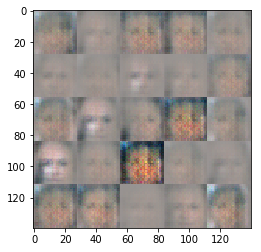

Epoch 0/1... Discriminator Loss: 0.4504... Generator Loss: 1.9849
Epoch 0/1... Discriminator Loss: 1.4308... Generator Loss: 0.4006
Epoch 0/1... Discriminator Loss: 0.5516... Generator Loss: 1.7448
Epoch 0/1... Discriminator Loss: 0.7430... Generator Loss: 1.4792
Epoch 0/1... Discriminator Loss: 0.7293... Generator Loss: 1.8591
Epoch 0/1... Discriminator Loss: 0.5383... Generator Loss: 1.3653
Epoch 0/1... Discriminator Loss: 0.8935... Generator Loss: 0.8424
Epoch 0/1... Discriminator Loss: 1.8927... Generator Loss: 3.6624
Epoch 0/1... Discriminator Loss: 0.7442... Generator Loss: 1.5302
Epoch 0/1... Discriminator Loss: 0.5178... Generator Loss: 1.4618


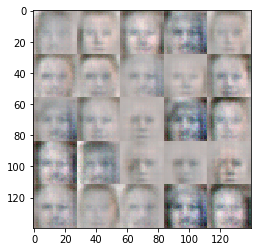

Epoch 0/1... Discriminator Loss: 1.1161... Generator Loss: 0.9155
Epoch 0/1... Discriminator Loss: 0.6206... Generator Loss: 1.5540
Epoch 0/1... Discriminator Loss: 0.6121... Generator Loss: 1.5010
Epoch 0/1... Discriminator Loss: 0.9810... Generator Loss: 1.0857
Epoch 0/1... Discriminator Loss: 0.8617... Generator Loss: 1.2038
Epoch 0/1... Discriminator Loss: 1.1398... Generator Loss: 0.8507
Epoch 0/1... Discriminator Loss: 0.9089... Generator Loss: 1.4833
Epoch 0/1... Discriminator Loss: 0.9286... Generator Loss: 1.1643
Epoch 0/1... Discriminator Loss: 1.0641... Generator Loss: 0.7767
Epoch 0/1... Discriminator Loss: 1.2112... Generator Loss: 0.7436


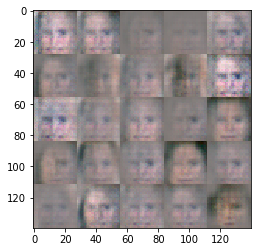

Epoch 0/1... Discriminator Loss: 1.1678... Generator Loss: 2.1633
Epoch 0/1... Discriminator Loss: 0.8575... Generator Loss: 0.9069
Epoch 0/1... Discriminator Loss: 0.7422... Generator Loss: 1.3391
Epoch 0/1... Discriminator Loss: 0.7969... Generator Loss: 1.3864
Epoch 0/1... Discriminator Loss: 1.0366... Generator Loss: 2.3595
Epoch 0/1... Discriminator Loss: 0.8083... Generator Loss: 1.5156
Epoch 0/1... Discriminator Loss: 0.8012... Generator Loss: 1.6236
Epoch 0/1... Discriminator Loss: 0.7210... Generator Loss: 1.1507
Epoch 0/1... Discriminator Loss: 0.9937... Generator Loss: 0.7177
Epoch 0/1... Discriminator Loss: 0.4596... Generator Loss: 2.0556


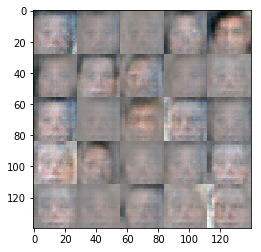

Epoch 0/1... Discriminator Loss: 1.4319... Generator Loss: 0.5738
Epoch 0/1... Discriminator Loss: 0.9202... Generator Loss: 1.5957
Epoch 0/1... Discriminator Loss: 0.9341... Generator Loss: 1.0996
Epoch 0/1... Discriminator Loss: 0.8723... Generator Loss: 1.0356
Epoch 0/1... Discriminator Loss: 1.6259... Generator Loss: 0.3943
Epoch 0/1... Discriminator Loss: 1.1852... Generator Loss: 0.5959
Epoch 0/1... Discriminator Loss: 0.9022... Generator Loss: 1.0286
Epoch 0/1... Discriminator Loss: 1.2838... Generator Loss: 0.5306
Epoch 0/1... Discriminator Loss: 1.0778... Generator Loss: 0.7953
Epoch 0/1... Discriminator Loss: 1.0846... Generator Loss: 0.7809


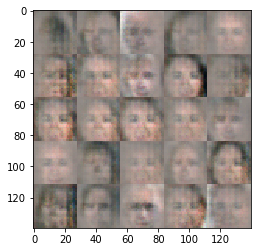

Epoch 0/1... Discriminator Loss: 0.9296... Generator Loss: 1.5863
Epoch 0/1... Discriminator Loss: 0.8099... Generator Loss: 1.3216
Epoch 0/1... Discriminator Loss: 0.9371... Generator Loss: 0.8758
Epoch 0/1... Discriminator Loss: 0.7755... Generator Loss: 1.7742
Epoch 0/1... Discriminator Loss: 1.0199... Generator Loss: 1.0472
Epoch 0/1... Discriminator Loss: 1.0022... Generator Loss: 1.3261
Epoch 0/1... Discriminator Loss: 0.9566... Generator Loss: 1.5471
Epoch 0/1... Discriminator Loss: 0.8255... Generator Loss: 1.5920
Epoch 0/1... Discriminator Loss: 1.3858... Generator Loss: 0.6006
Epoch 0/1... Discriminator Loss: 0.8199... Generator Loss: 1.1267


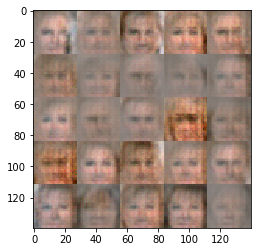

Epoch 0/1... Discriminator Loss: 0.8892... Generator Loss: 1.1552
Epoch 0/1... Discriminator Loss: 0.9181... Generator Loss: 1.2312
Epoch 0/1... Discriminator Loss: 1.1193... Generator Loss: 0.7447
Epoch 0/1... Discriminator Loss: 1.0081... Generator Loss: 0.7831
Epoch 0/1... Discriminator Loss: 1.0152... Generator Loss: 1.0524
Epoch 0/1... Discriminator Loss: 0.9200... Generator Loss: 0.8711
Epoch 0/1... Discriminator Loss: 0.8147... Generator Loss: 0.9621
Epoch 0/1... Discriminator Loss: 0.7986... Generator Loss: 1.1009
Epoch 0/1... Discriminator Loss: 0.8795... Generator Loss: 1.4096
Epoch 0/1... Discriminator Loss: 1.4799... Generator Loss: 2.3157


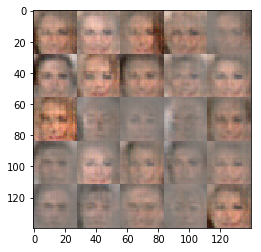

Epoch 0/1... Discriminator Loss: 0.8314... Generator Loss: 1.3249
Epoch 0/1... Discriminator Loss: 1.2147... Generator Loss: 2.3562
Epoch 0/1... Discriminator Loss: 1.2177... Generator Loss: 0.5159
Epoch 0/1... Discriminator Loss: 0.9759... Generator Loss: 1.5920
Epoch 0/1... Discriminator Loss: 0.9456... Generator Loss: 0.8720
Epoch 0/1... Discriminator Loss: 0.8600... Generator Loss: 1.0506
Epoch 0/1... Discriminator Loss: 0.9056... Generator Loss: 1.0544
Epoch 0/1... Discriminator Loss: 0.8351... Generator Loss: 0.8869
Epoch 0/1... Discriminator Loss: 0.9204... Generator Loss: 1.6748
Epoch 0/1... Discriminator Loss: 0.8759... Generator Loss: 1.6063


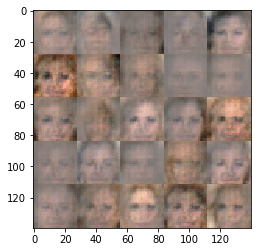

Epoch 0/1... Discriminator Loss: 1.0087... Generator Loss: 0.8450
Epoch 0/1... Discriminator Loss: 0.8365... Generator Loss: 1.5767
Epoch 0/1... Discriminator Loss: 0.8301... Generator Loss: 1.1050
Epoch 0/1... Discriminator Loss: 0.8785... Generator Loss: 1.0864
Epoch 0/1... Discriminator Loss: 1.1126... Generator Loss: 0.9064
Epoch 0/1... Discriminator Loss: 0.9251... Generator Loss: 1.6967
Epoch 0/1... Discriminator Loss: 0.8619... Generator Loss: 0.9525
Epoch 0/1... Discriminator Loss: 1.4837... Generator Loss: 0.4237
Epoch 0/1... Discriminator Loss: 1.1800... Generator Loss: 0.7001
Epoch 0/1... Discriminator Loss: 1.0625... Generator Loss: 1.9089


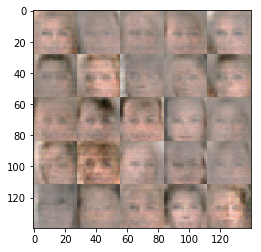

Epoch 0/1... Discriminator Loss: 1.0728... Generator Loss: 2.2724
Epoch 0/1... Discriminator Loss: 0.8934... Generator Loss: 1.1253
Epoch 0/1... Discriminator Loss: 1.1362... Generator Loss: 0.5496
Epoch 0/1... Discriminator Loss: 1.1872... Generator Loss: 2.2433
Epoch 0/1... Discriminator Loss: 0.9738... Generator Loss: 0.8098
Epoch 0/1... Discriminator Loss: 0.9940... Generator Loss: 0.7519
Epoch 0/1... Discriminator Loss: 0.7216... Generator Loss: 1.6684
Epoch 0/1... Discriminator Loss: 0.8356... Generator Loss: 1.6626
Epoch 0/1... Discriminator Loss: 1.0442... Generator Loss: 1.1655
Epoch 0/1... Discriminator Loss: 0.9088... Generator Loss: 0.9229


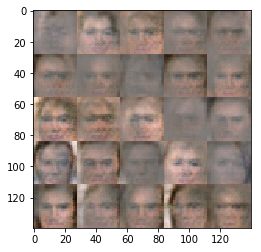

Epoch 0/1... Discriminator Loss: 0.7184... Generator Loss: 1.6292
Epoch 0/1... Discriminator Loss: 0.9517... Generator Loss: 1.1121
Epoch 0/1... Discriminator Loss: 0.8757... Generator Loss: 0.9168
Epoch 0/1... Discriminator Loss: 0.9592... Generator Loss: 1.7628
Epoch 0/1... Discriminator Loss: 0.8664... Generator Loss: 1.4914
Epoch 0/1... Discriminator Loss: 1.0662... Generator Loss: 1.7648
Epoch 0/1... Discriminator Loss: 0.9531... Generator Loss: 1.8939
Epoch 0/1... Discriminator Loss: 1.1153... Generator Loss: 1.5780
Epoch 0/1... Discriminator Loss: 0.9815... Generator Loss: 0.9533
Epoch 0/1... Discriminator Loss: 0.7538... Generator Loss: 2.1685


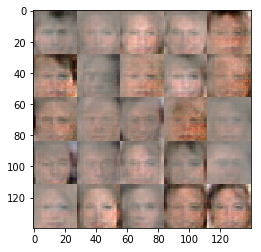

Epoch 0/1... Discriminator Loss: 0.8079... Generator Loss: 1.0812
Epoch 0/1... Discriminator Loss: 1.0740... Generator Loss: 0.6600
Epoch 0/1... Discriminator Loss: 1.5341... Generator Loss: 0.3774
Epoch 0/1... Discriminator Loss: 0.7775... Generator Loss: 1.2709
Epoch 0/1... Discriminator Loss: 0.8364... Generator Loss: 1.8142
Epoch 0/1... Discriminator Loss: 1.0782... Generator Loss: 1.4689
Epoch 0/1... Discriminator Loss: 1.5360... Generator Loss: 0.3772
Epoch 0/1... Discriminator Loss: 1.0783... Generator Loss: 1.3409
Epoch 0/1... Discriminator Loss: 1.4965... Generator Loss: 0.4189
Epoch 0/1... Discriminator Loss: 0.9852... Generator Loss: 1.2419


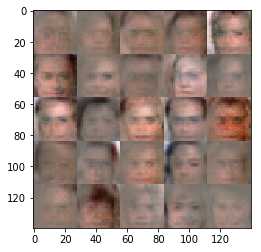

Epoch 0/1... Discriminator Loss: 1.0824... Generator Loss: 1.7389
Epoch 0/1... Discriminator Loss: 0.9784... Generator Loss: 1.1434
Epoch 0/1... Discriminator Loss: 1.2123... Generator Loss: 2.6191
Epoch 0/1... Discriminator Loss: 0.8897... Generator Loss: 1.1007
Epoch 0/1... Discriminator Loss: 1.1065... Generator Loss: 1.0013
Epoch 0/1... Discriminator Loss: 0.9719... Generator Loss: 1.0469
Epoch 0/1... Discriminator Loss: 0.8201... Generator Loss: 1.1165
Epoch 0/1... Discriminator Loss: 0.8275... Generator Loss: 2.4778
Epoch 0/1... Discriminator Loss: 1.0670... Generator Loss: 0.6166
Epoch 0/1... Discriminator Loss: 1.0927... Generator Loss: 1.3459


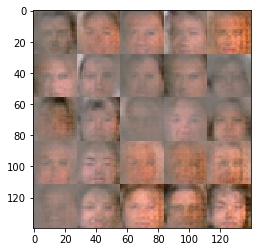

Epoch 0/1... Discriminator Loss: 0.9357... Generator Loss: 1.0895
Epoch 0/1... Discriminator Loss: 0.9805... Generator Loss: 1.2891
Epoch 0/1... Discriminator Loss: 0.7498... Generator Loss: 1.4002
Epoch 0/1... Discriminator Loss: 1.2144... Generator Loss: 0.5266
Epoch 0/1... Discriminator Loss: 1.2411... Generator Loss: 0.6072
Epoch 0/1... Discriminator Loss: 1.0139... Generator Loss: 1.0864
Epoch 0/1... Discriminator Loss: 0.9278... Generator Loss: 1.1732
Epoch 0/1... Discriminator Loss: 1.0320... Generator Loss: 0.8994
Epoch 0/1... Discriminator Loss: 0.7131... Generator Loss: 1.5442
Epoch 0/1... Discriminator Loss: 0.8762... Generator Loss: 1.2827


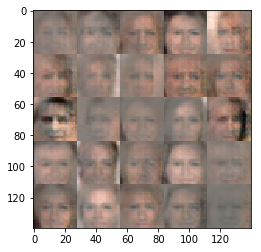

Epoch 0/1... Discriminator Loss: 0.9555... Generator Loss: 1.1327
Epoch 0/1... Discriminator Loss: 1.1059... Generator Loss: 0.8283
Epoch 0/1... Discriminator Loss: 0.7497... Generator Loss: 0.9203
Epoch 0/1... Discriminator Loss: 0.8807... Generator Loss: 1.4724
Epoch 0/1... Discriminator Loss: 0.8855... Generator Loss: 1.0351
Epoch 0/1... Discriminator Loss: 1.0934... Generator Loss: 0.8693
Epoch 0/1... Discriminator Loss: 0.7284... Generator Loss: 1.4703
Epoch 0/1... Discriminator Loss: 0.7214... Generator Loss: 1.1324
Epoch 0/1... Discriminator Loss: 0.7142... Generator Loss: 1.2268
Epoch 0/1... Discriminator Loss: 1.1084... Generator Loss: 0.6594


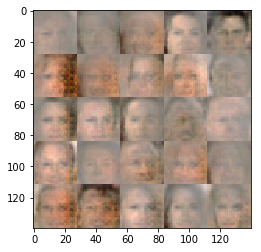

Epoch 0/1... Discriminator Loss: 1.2842... Generator Loss: 0.5581
Epoch 0/1... Discriminator Loss: 1.3536... Generator Loss: 0.4719
Epoch 0/1... Discriminator Loss: 0.9576... Generator Loss: 0.8676
Epoch 0/1... Discriminator Loss: 0.9626... Generator Loss: 1.6912
Epoch 0/1... Discriminator Loss: 1.0636... Generator Loss: 0.7911
Epoch 0/1... Discriminator Loss: 0.9307... Generator Loss: 0.9789
Epoch 0/1... Discriminator Loss: 0.9485... Generator Loss: 0.8756
Epoch 0/1... Discriminator Loss: 1.1229... Generator Loss: 0.5767
Epoch 0/1... Discriminator Loss: 0.9824... Generator Loss: 0.9950
Epoch 0/1... Discriminator Loss: 0.9887... Generator Loss: 1.6788


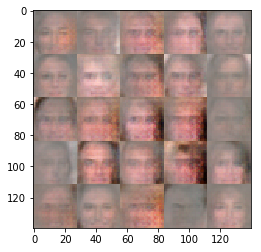

Epoch 0/1... Discriminator Loss: 0.9727... Generator Loss: 1.2380
Epoch 0/1... Discriminator Loss: 1.0983... Generator Loss: 0.9651
Epoch 0/1... Discriminator Loss: 0.7131... Generator Loss: 1.2422
Epoch 0/1... Discriminator Loss: 0.8134... Generator Loss: 1.2613
Epoch 0/1... Discriminator Loss: 1.1216... Generator Loss: 1.2859
Epoch 0/1... Discriminator Loss: 1.1542... Generator Loss: 1.0311
Epoch 0/1... Discriminator Loss: 0.8782... Generator Loss: 0.9356
Epoch 0/1... Discriminator Loss: 1.1719... Generator Loss: 0.5469
Epoch 0/1... Discriminator Loss: 0.9428... Generator Loss: 1.3536
Epoch 0/1... Discriminator Loss: 1.0028... Generator Loss: 0.7968


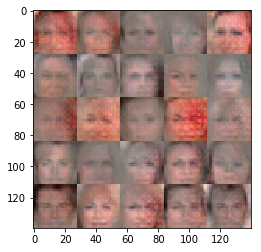

Epoch 0/1... Discriminator Loss: 0.9370... Generator Loss: 0.9096
Epoch 0/1... Discriminator Loss: 1.0358... Generator Loss: 0.9527
Epoch 0/1... Discriminator Loss: 0.9781... Generator Loss: 1.5166
Epoch 0/1... Discriminator Loss: 0.8864... Generator Loss: 0.9680
Epoch 0/1... Discriminator Loss: 0.8915... Generator Loss: 0.9769
Epoch 0/1... Discriminator Loss: 1.0683... Generator Loss: 2.1297
Epoch 0/1... Discriminator Loss: 0.9782... Generator Loss: 0.8261
Epoch 0/1... Discriminator Loss: 0.9006... Generator Loss: 0.9205
Epoch 0/1... Discriminator Loss: 1.0798... Generator Loss: 0.7362
Epoch 0/1... Discriminator Loss: 0.9268... Generator Loss: 1.3532


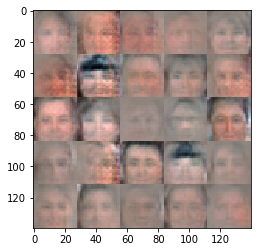

Epoch 0/1... Discriminator Loss: 0.9010... Generator Loss: 1.4752
Epoch 0/1... Discriminator Loss: 0.9371... Generator Loss: 1.0279
Epoch 0/1... Discriminator Loss: 0.8046... Generator Loss: 0.9276
Epoch 0/1... Discriminator Loss: 0.8346... Generator Loss: 1.0569
Epoch 0/1... Discriminator Loss: 1.1654... Generator Loss: 0.5245
Epoch 0/1... Discriminator Loss: 0.9245... Generator Loss: 1.4243
Epoch 0/1... Discriminator Loss: 0.8022... Generator Loss: 1.4315
Epoch 0/1... Discriminator Loss: 0.9277... Generator Loss: 1.2010
Epoch 0/1... Discriminator Loss: 1.0689... Generator Loss: 0.5926
Epoch 0/1... Discriminator Loss: 1.2099... Generator Loss: 2.0362


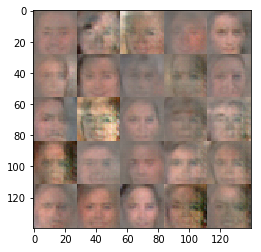

Epoch 0/1... Discriminator Loss: 0.7917... Generator Loss: 1.8295
Epoch 0/1... Discriminator Loss: 0.8614... Generator Loss: 1.1646
Epoch 0/1... Discriminator Loss: 1.0464... Generator Loss: 0.7802
Epoch 0/1... Discriminator Loss: 0.8526... Generator Loss: 1.5013
Epoch 0/1... Discriminator Loss: 1.1140... Generator Loss: 1.8105
Epoch 0/1... Discriminator Loss: 1.0591... Generator Loss: 0.6924
Epoch 0/1... Discriminator Loss: 0.7870... Generator Loss: 1.3518
Epoch 0/1... Discriminator Loss: 0.9984... Generator Loss: 0.8554
Epoch 0/1... Discriminator Loss: 0.8915... Generator Loss: 1.4527
Epoch 0/1... Discriminator Loss: 1.1209... Generator Loss: 0.5578


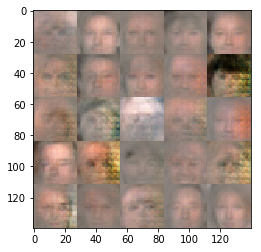

Epoch 0/1... Discriminator Loss: 0.9806... Generator Loss: 1.3413
Epoch 0/1... Discriminator Loss: 1.5056... Generator Loss: 0.3638
Epoch 0/1... Discriminator Loss: 1.2642... Generator Loss: 0.4793
Epoch 0/1... Discriminator Loss: 1.0905... Generator Loss: 0.8622
Epoch 0/1... Discriminator Loss: 0.8852... Generator Loss: 0.9838
Epoch 0/1... Discriminator Loss: 0.8228... Generator Loss: 0.8958
Epoch 0/1... Discriminator Loss: 1.2059... Generator Loss: 0.5538
Epoch 0/1... Discriminator Loss: 0.8388... Generator Loss: 1.2669
Epoch 0/1... Discriminator Loss: 0.9736... Generator Loss: 1.0993
Epoch 0/1... Discriminator Loss: 1.0274... Generator Loss: 1.2088


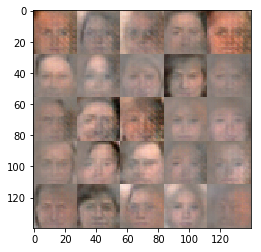

Epoch 0/1... Discriminator Loss: 0.9536... Generator Loss: 0.9918
Epoch 0/1... Discriminator Loss: 1.0699... Generator Loss: 0.7278
Epoch 0/1... Discriminator Loss: 1.1041... Generator Loss: 0.5931
Epoch 0/1... Discriminator Loss: 0.9065... Generator Loss: 1.1135
Epoch 0/1... Discriminator Loss: 0.8400... Generator Loss: 1.2550
Epoch 0/1... Discriminator Loss: 1.1319... Generator Loss: 0.6160
Epoch 0/1... Discriminator Loss: 0.9082... Generator Loss: 0.9615
Epoch 0/1... Discriminator Loss: 1.0950... Generator Loss: 0.9891
Epoch 0/1... Discriminator Loss: 0.9288... Generator Loss: 1.2394
Epoch 0/1... Discriminator Loss: 1.1590... Generator Loss: 0.5776


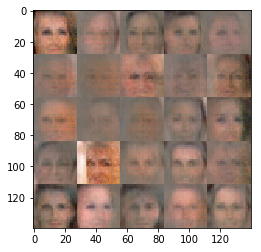

Epoch 0/1... Discriminator Loss: 1.1031... Generator Loss: 0.8169
Epoch 0/1... Discriminator Loss: 0.6800... Generator Loss: 1.3127
Epoch 0/1... Discriminator Loss: 1.0394... Generator Loss: 1.6960
Epoch 0/1... Discriminator Loss: 1.0150... Generator Loss: 0.8039
Epoch 0/1... Discriminator Loss: 0.9529... Generator Loss: 0.8550
Epoch 0/1... Discriminator Loss: 0.8989... Generator Loss: 0.9241
Epoch 0/1... Discriminator Loss: 1.0329... Generator Loss: 0.6167
Epoch 0/1... Discriminator Loss: 1.5182... Generator Loss: 0.3334
Epoch 0/1... Discriminator Loss: 1.1194... Generator Loss: 0.6067
Epoch 0/1... Discriminator Loss: 0.9746... Generator Loss: 0.9037


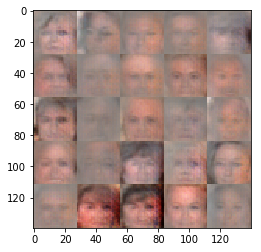

Epoch 0/1... Discriminator Loss: 0.7674... Generator Loss: 1.8714
Epoch 0/1... Discriminator Loss: 0.9601... Generator Loss: 0.7696
Epoch 0/1... Discriminator Loss: 1.1647... Generator Loss: 2.2624
Epoch 0/1... Discriminator Loss: 1.3003... Generator Loss: 0.4754
Epoch 0/1... Discriminator Loss: 1.2210... Generator Loss: 0.6924
Epoch 0/1... Discriminator Loss: 1.0713... Generator Loss: 0.6333
Epoch 0/1... Discriminator Loss: 0.9644... Generator Loss: 2.0567
Epoch 0/1... Discriminator Loss: 0.9576... Generator Loss: 0.9731
Epoch 0/1... Discriminator Loss: 0.9537... Generator Loss: 0.7229
Epoch 0/1... Discriminator Loss: 1.0192... Generator Loss: 2.1441


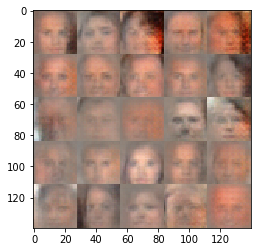

Epoch 0/1... Discriminator Loss: 0.9381... Generator Loss: 1.4620
Epoch 0/1... Discriminator Loss: 1.1333... Generator Loss: 0.5592
Epoch 0/1... Discriminator Loss: 1.1839... Generator Loss: 0.7499
Epoch 0/1... Discriminator Loss: 0.7185... Generator Loss: 1.4118
Epoch 0/1... Discriminator Loss: 1.0535... Generator Loss: 0.6231
Epoch 0/1... Discriminator Loss: 0.9020... Generator Loss: 0.9810
Epoch 0/1... Discriminator Loss: 0.9957... Generator Loss: 1.1548
Epoch 0/1... Discriminator Loss: 0.9771... Generator Loss: 0.7153
Epoch 0/1... Discriminator Loss: 0.6869... Generator Loss: 1.6017
Epoch 0/1... Discriminator Loss: 1.1761... Generator Loss: 0.6009


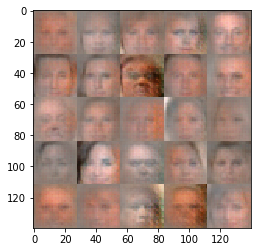

Epoch 0/1... Discriminator Loss: 0.9660... Generator Loss: 0.8075
Epoch 0/1... Discriminator Loss: 1.2281... Generator Loss: 0.5167
Epoch 0/1... Discriminator Loss: 0.8698... Generator Loss: 1.2465
Epoch 0/1... Discriminator Loss: 1.0947... Generator Loss: 0.9824
Epoch 0/1... Discriminator Loss: 1.1031... Generator Loss: 0.6055
Epoch 0/1... Discriminator Loss: 0.7336... Generator Loss: 1.4818
Epoch 0/1... Discriminator Loss: 0.8203... Generator Loss: 1.1495
Epoch 0/1... Discriminator Loss: 0.8815... Generator Loss: 1.0209
Epoch 0/1... Discriminator Loss: 1.5395... Generator Loss: 0.3290
Epoch 0/1... Discriminator Loss: 0.8011... Generator Loss: 1.3955


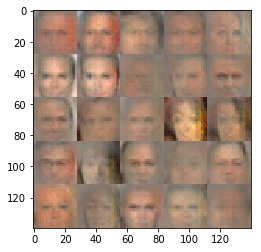

Epoch 0/1... Discriminator Loss: 0.7786... Generator Loss: 1.0131
Epoch 0/1... Discriminator Loss: 0.8446... Generator Loss: 1.3367
Epoch 0/1... Discriminator Loss: 1.0988... Generator Loss: 0.7436
Epoch 0/1... Discriminator Loss: 1.1932... Generator Loss: 0.9893
Epoch 0/1... Discriminator Loss: 0.9961... Generator Loss: 0.9154
Epoch 0/1... Discriminator Loss: 1.0384... Generator Loss: 0.7185
Epoch 0/1... Discriminator Loss: 0.8085... Generator Loss: 1.4289
Epoch 0/1... Discriminator Loss: 1.0105... Generator Loss: 1.2051
Epoch 0/1... Discriminator Loss: 1.2659... Generator Loss: 0.5256
Epoch 0/1... Discriminator Loss: 0.9509... Generator Loss: 1.0474


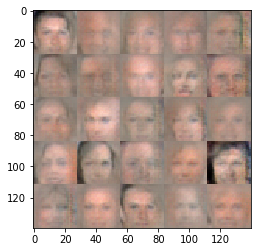

Epoch 0/1... Discriminator Loss: 0.8606... Generator Loss: 1.3248
Epoch 0/1... Discriminator Loss: 0.9851... Generator Loss: 0.8811
Epoch 0/1... Discriminator Loss: 1.0770... Generator Loss: 0.7284
Epoch 0/1... Discriminator Loss: 1.3278... Generator Loss: 1.3493
Epoch 0/1... Discriminator Loss: 0.9783... Generator Loss: 1.5812
Epoch 0/1... Discriminator Loss: 0.9724... Generator Loss: 1.4923
Epoch 0/1... Discriminator Loss: 0.8458... Generator Loss: 0.9647


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.